In [1]:
from tensorflow.keras import models
import tensorflow.keras.backend as K
import tensorflow as tf
from sklearn.model_selection import train_test_split
import librosa
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import time
import edit_distance as ed
from tensorflow.keras.callbacks import ModelCheckpoint
import os

# Utils-------------------------------------------------------------------------------------------------

In [2]:
device_name = '/device:GPU:0'

# U.0
# Loads model from the directory argument

In [3]:
def load_model(model_dir):
    return models.load_model(model_dir)

# U.1
# Loading wav file from librosa

In [4]:
def load_wav(dir):
    return librosa.load(dir, sr=SR)[0]

# U.2
# Generates Normalized MFCCs from audio

In [5]:
def gen_mfcc(arr):
    mfccs = librosa.feature.mfcc(
        y=arr[:-1], sr=SR, n_mfcc=N_MFCC, hop_length=HOP_LENGTH).transpose().flatten()
    return (mfccs - np.mean(mfccs)) / np.std(mfccs)

# U.3
# Generates padded text from list of texts

In [6]:
def pad_text(list_texts, unq_chars, unk_idx=1):
    max_len = max([len(txt) for txt in list_texts])
    padded_arr = []
    seq_lengths = []

    for txt in list_texts:
        len_seq = len(txt)
        txt += "0" * (max_len - len_seq)

        # index 1 for the unknown chars
        arr = np.array(
            [unq_chars.index(ch) if ch in unq_chars else unk_idx for ch in txt])

        padded_arr.append(arr)
        seq_lengths.append(len_seq)

    return np.array(padded_arr), np.array(seq_lengths)

# U.4
# Returns tensor batch*seq*frame

In [7]:
def pad_list_np(list_np):
    max_len = max([len(arr) for arr in list_np])

    # So that the numpy array can be reshaped according to the input dimension
    max_len += INPUT_DIM - (max_len % INPUT_DIM)

    padded_arr = []

    for arr in list_np:
        len_seq = len(arr)
        arr = np.pad(arr, (0, max_len - len_seq), constant_values=0)
        padded_arr.append(arr)

    return np.array(padded_arr).reshape((len(list_np), -1, INPUT_DIM))

# U.5
# Generates batches of wavs and texts  with padding as per needed

In [8]:
def batchify(wavs, texts, unq_chars):
    assert len(wavs) == len(texts)
    # generates tensor of dim (batch * seq * frame)
    input_tensor = pad_list_np(wavs)
    target_tensor, target_lengths_tensor = pad_text(texts, unq_chars)
    output_seq_lengths_tensor = np.full(
        (len(wavs),), fill_value=input_tensor.shape[1])

    return input_tensor, target_tensor, target_lengths_tensor.reshape((-1, 1)), output_seq_lengths_tensor.reshape((-1, 1))

# U.6
# Plots lossses from the file

In [9]:
def plot_losses(dir, optimal_epoch=None):
    losses = None
    with open(dir, "rb") as f:
        losses = pickle.load(f)
        f.close()

    train_losses, test_losses = losses["train_losses"], losses["test_losses"]
    epochs = len(train_losses)
    # print(len(test_losses))

    X = range(1, epochs+1)

    fig, ax = plt.subplots(1, figsize=(15, 10))

    fig.suptitle('Train and Test Losses', fontsize=25,)

    ax.set_xlim(0, 72)
    ax.plot(X, train_losses, color="red", label="Train Loss")
    ax.plot(X, test_losses, color="green", label="Test Loss")

    plt.rcParams.update({'font.size': 20})

    plt.legend(loc="upper right", frameon=False, fontsize=20)
    # plt.xlabel("Epochs",{"size":20})
    # plt.ylabel("Loss", {"size":20})

    if (optimal_epoch != None):
        plt.axvline(x=optimal_epoch, ymax=0.5)
        # ax.plot(58, 0, 'go', label='marker only')
        plt.text(optimal_epoch, 35,
                 f'Optimal Epoch at {optimal_epoch}', fontsize=15)

    plt.show()

# U.7
# Decoding with prefix beam search from MFCC features only

In [10]:
def predict_from_mfccs(model, mfccs, unq_chars):

    mfccs = pad_list_np(mfccs)  # coverts the data to 3d
    pred = model(mfccs, training=False)

    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = K.ctc_decode(pred, input_length=input_len,
                           greedy=False, beam_width=100)[0][0]

    sentences = []
    char_indices = []
    for chars_indices in results:

        sent = ""
        temp_indices = []
        for idx in chars_indices:

            if idx > 1:
                sent += unq_chars[idx]
                temp_indices.append(idx.numpy())
        sentences.append(sent)
        char_indices.append(temp_indices)
    return sentences, char_indices

# U.8
# Decoding with prefix beam search from wavs only

In [11]:
def predict_from_wavs(model, wavs, unq_chars):
    mfccs = [gen_mfcc(wav) for wav in wavs]
    return predict_from_mfccs(model, mfccs, unq_chars)

# U.9
# Converts the text to list of indices as per the unique characters list

In [12]:
def indices_from_texts(texts_list, unq_chars, unk_idx=1):

    indices_list = []
    for txt in texts_list:

        # index 1 for the unknown chars
        lst = [unq_chars.index(
            ch) if ch in unq_chars else unk_idx for ch in txt]

        indices_list.append(lst)

    return indices_list

'''
Calculates CER( character error rate) from dataset;
'''
# U.10
# CER from mfccs

In [13]:
def CER_from_mfccs(model, mfccs, texts, unq_chars, batch_size=100):

    with tf.device(device_name):

        len_mfccs = len(mfccs)
        batch_count = 0
        sum_cer = 0

        start_time = time.time()
        for start in range(0, len_mfccs, batch_size):
            end = None
            if start + batch_size < len_mfccs:
                end = start + batch_size
            else:
                end = len_mfccs
            pred_sentences, pred_indices = predict_from_mfccs(
                model, mfccs[start:end], unq_chars)
            actual_indices = indices_from_texts(texts[start:end], unq_chars)

            len_batch_texts = end - start
            batch_cer = 0
            for i in range(len_batch_texts):

                pred = pred_indices[i]
                actu = actual_indices[i]

                sm = ed.SequenceMatcher(pred, actu)
                ed_dist = sm.distance()
                batch_cer += ed_dist / len(actu)

            batch_cer /= len_batch_texts
            batch_count += 1
            sum_cer += batch_cer

            print("CER -> {:.2f}%, \t No.of sentences -> {}, \t Time Taken -> {:.2f} secs.".format(
                (sum_cer / batch_count) * 100, end, time.time() - start_time))

        print(
            "The total time taken for all sentences CER calculation is  {:.2f} secs.".format(time.time() - start_time))
        return sum_cer / batch_count

# U.11
# CER from wavs

In [14]:
def CER_from_wavs(model, wavs, texts, unq_chars, batch_size=100):

    assert len(wavs) == len(texts)

    len_wavs = len(wavs)
    for i in range(len_wavs):
        wavs[i] = gen_mfcc(wavs[i])

    return CER_from_mfccs(model, wavs, texts, unq_chars, batch_size)

# U.12
# CTC softmax probabilities output from mfcc features

In [15]:
def ctc_softmax_output_from_mfccs(model, mfccs):
    mfccs = pad_list_np(mfccs)
    y = model(mfccs)
    return y

# U.13
# CTC softmax probabilities output from wavs

In [16]:
def ctc_softmax_output_from_wavs(model, wavs):
    mfccs = [gen_mfcc(wav) for wav in wavs]
    return ctc_softmax_output_from_mfccs(model, mfccs)

# U.14
# Clean the single audio file by clipping silent gaps from both ends

In [17]:
def clean_single_wav(wav, win_size=500):
    wav_avg = np.average(np.absolute(wav))

    for s in range(0, len(wav)-win_size, win_size):
        window = wav[s:s+win_size]
        if np.average(np.absolute(window)) > wav_avg:
            wav = wav[s:]
            break

    for s in range(len(wav)-win_size, 0, -win_size):
        window = wav[s-win_size:s]
        if np.average(np.absolute(window)) > wav_avg:
            wav = wav[:s]
            break

    pad = FRAME_SIZE - len(wav) % FRAME_SIZE
    wav = np.pad(wav, (0, pad), mode="mean")
    return wav

# Necessary Global Configs-------------------------------------------------------------------------

In [18]:
LOAD_MFCC_FILES = True
FRAME_SIZE = 160
SR = 16000
FRAME_RATE = int( SR / FRAME_SIZE )
N_MFCC = 13
HOP_LENGTH = 40

In [20]:
assert FRAME_SIZE % HOP_LENGTH == 0

In [19]:
INPUT_DIM = int(N_MFCC * (FRAME_SIZE / HOP_LENGTH))

In [21]:
UNQ_CHARS = [' ', 'ँ', 'ं', 'ः', 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ए', 'ऐ', 'ओ', 'औ', 'क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'व', 'श', 'ष', 'स', 'ह', 'ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'े', 'ै', 'ो', 'ौ', '्', 'ॠ', '\u200c', '\u200d', '।']
UNQ_CHARS = ['0', 'u' ] + sorted(UNQ_CHARS) + ['-'] #"0" -> padding char,"u" -> unknown chars "-" -> blank char
NUM_UNQ_CHARS = len(UNQ_CHARS) # +1 is for '-' blank at last

In [22]:
MODEL_NAME = "ASR_model"

# Checks for the availability of the GPU

In [23]:
device_name = tf.test.gpu_device_name()
device_name

''

In [24]:
if device_name != '/device:GPU:0':
    device_name = '/device:CPU:0'
device_name

'/device:CPU:0'

# Model ----------------------------------------------------------------------------------------------

In [25]:
from tensorflow.keras import layers, Model, Input

# Residual block for the model

In [26]:
def res_block(ip, num_cnn_layers, cnn_filters, cnn_kernel_size, use_resnet):

    res_arch = ip
    for _ in range(num_cnn_layers):
        res_arch = layers.Conv1D(
            cnn_filters, cnn_kernel_size, padding='same')(res_arch)
        res_arch = layers.BatchNormalization()(res_arch)
        res_arch = layers.PReLU(shared_axes=[1])(res_arch)

    return layers.add([ip, res_arch]) if use_resnet else res_arch

# Main ASR model

In [27]:
def get_model(ip_channel, num_classes, num_res_blocks=3, num_cnn_layers=1, cnn_filters=50,
             cnn_kernel_size=15,  num_rnn_layers=2, rnn_dim=170, num_dense_layers=1,
             dense_dim=300, use_birnn=True, use_resnet=True, rnn_type="lstm", rnn_dropout=0.15,
             model_name=None):

    input = Input(shape=(None, ip_channel))

    arch = layers.Conv1D(cnn_filters, cnn_kernel_size, padding="same")(input)
    arch = layers.BatchNormalization()(arch)
    arch = layers.PReLU(shared_axes=[1])(arch)

    for _ in range(num_res_blocks):
        arch = res_block(arch, num_cnn_layers, cnn_filters,
                         cnn_kernel_size, use_resnet)

    rnn = layers.GRU if rnn_type == "gru" else layers.LSTM

    for _ in range(num_rnn_layers):
        if use_birnn:
            arch = layers.Bidirectional(
                rnn(rnn_dim, dropout=rnn_dropout, return_sequences=True))(arch)
        else:
            arch = rnn(rnn_dim, dropout=rnn_dropout,
                       return_sequences=True)(arch)

    for _ in range(num_dense_layers):
        arch = layers.Dense(dense_dim)(arch)
        arch = layers.ReLU()(arch)

    arch = layers.Dense(num_classes)(arch)
    output = K.softmax(arch)

    model = Model(inputs=input, outputs=output, name=model_name)

    return model

# Defintion of the model

In [28]:
if __name__ == "__main__":
    
    model = get_model(INPUT_DIM, NUM_UNQ_CHARS, num_res_blocks=5, num_cnn_layers=2,
                     cnn_filters=50, cnn_kernel_size=15, rnn_dim=170, num_rnn_layers=2,
                     num_dense_layers=1, dense_dim=340, model_name=MODEL_NAME, rnn_type="lstm",
                     use_birnn=True)
    x = np.random.rand(2, 100, INPUT_DIM)
    y = model(x)
    print(y.shape)

(2, 100, 66)


# Summary of model

In [29]:
model.summary()

Model: "ASR_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 52)]           0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, None, 50)             39050     ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, 50)             200       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 p_re_lu (PReLU)             (None, None, 50)             50        ['batch_normalization[

                                                                    ]                             
                                                                                                  
 add_3 (Add)                 (None, None, 50)             0         ['add_2[0][0]',               
                                                                     'p_re_lu_8[0][0]']           
                                                                                                  
 conv1d_9 (Conv1D)           (None, None, 50)             37550     ['add_3[0][0]']               
                                                                                                  
 batch_normalization_9 (Bat  (None, None, 50)             200       ['conv1d_9[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 p_re_lu_9

# Training

In [74]:
def train_model(model, optimizer, train_wavs, train_texts, test_wavs, test_texts, epochs=58, batch_size=50):
    train_losses = []
    test_losses = []

    with tf.device(device_name):  # Assuming device_name is defined somewhere
        # Define a callback to save the model checkpoints
        checkpoint_filepath = 'model/checkpoints/model_checkpoint_asr0.h5'
        if checkpoint_filepath is not None:
            model_checkpoint_callback = ModelCheckpoint(
                filepath=checkpoint_filepath,
                save_weights_only=True,
                monitor='val_loss',
                mode='min',
                save_best_only=True
            )

        for e in range(0, epochs):
            start_time = time.time()

            len_train = len(train_wavs)
            len_test = len(test_wavs)
            train_loss = 0
            test_loss = 0
            test_CER = 0
            train_batch_count = 0
            test_batch_count = 0

            print("Training epoch: {}".format(e + 1))
            for start in tqdm(range(0, len_train, batch_size)):
                end = min(start + batch_size, len_train)
                x, target, target_lengths, output_lengths = batchify(
                    train_wavs[start:end], train_texts[start:end], UNQ_CHARS)

                with tf.GradientTape() as tape:
                    output = model(x, training=True)

                    loss = K.ctc_batch_cost(
                        target, output, output_lengths, target_lengths)

                grads = tape.gradient(loss, model.trainable_weights)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))

                train_loss += np.average(loss.numpy())
                train_batch_count += 1

            print("Testing epoch: {}".format(e + 1))
            for start in tqdm(range(0, len_test, batch_size)):
                end = min(start + batch_size, len_test)
                x, target, target_lengths, output_lengths = batchify(
                    test_wavs[start:end], test_texts[start:end], UNQ_CHARS)

                output = model(x, training=False)

                # Calculate CTC Loss
                loss = K.ctc_batch_cost(
                    target, output, output_lengths, target_lengths)

                test_loss += np.average(loss.numpy())
                test_batch_count += 1

                """
                The line of codes below is for computing evaluation metric (CER) on internal validation data.
                """
                input_len = np.ones(output.shape[0]) * output.shape[1]
                decoded_indices = K.ctc_decode(output, input_length=input_len,
                                               greedy=False, beam_width=100)[0][0]

                # Remove the padding token from batchified target texts
                target_indices = [sent[sent != 0].tolist() for sent in target]

                # Remove the padding, unknown token, and blank token from predicted texts
                predicted_indices = [sent[sent > 1].numpy().tolist() for sent in decoded_indices]

                len_batch = end - start
                for i in range(len_batch):
                    pred = predicted_indices[i]
                    truth = target_indices[i]
                    sm = ed.SequenceMatcher(pred, truth)
                    ed_dist = sm.distance()  # Edit distance
                    test_CER += ed_dist / len(truth)
                test_CER /= len_batch

            train_loss /= train_batch_count
            test_loss /= test_batch_count
            test_CER /= test_batch_count

            train_losses.append(train_loss)
            test_losses.append(test_loss)

            rec = "Epoch: {}, Train Loss: {:.2f}, Test Loss {:.2f}, Test CER {:.2f} % in {:.2f} secs.\n".format(
                e + 1, train_loss, test_loss, test_CER * 100, time.time() - start_time)

            print(rec)

            # Save the model and losses for each epoch
            if checkpoint_filepath is not None:
                model.save(checkpoint_filepath.format(epoch=e + 1), include_optimizer=True)

            # Save the losses to a pickle file for each epoch
            losses_data = {
                'train_losses': train_losses,
                'test_losses': test_losses
            }

            with open('losses_epoch_{}.pkl'.format(e + 1), 'wb') as f:
                pickle.dump(losses_data, f)

    # Save the final trained model
    model.save("model/trained_model_asr0.h5", include_optimizer=True)


In [31]:
def load_data(wavs_dir, texts_dir):
    texts_df = pd.read_csv(texts_dir)
    train_wavs = []
    for f_name in texts_df["file"]:
        wav, _ = librosa.load(f"{wavs_dir}/{f_name}.flac", sr=SR)
        train_wavs.append(wav)
    train_texts = texts_df["text"].tolist()
    return train_wavs, train_texts

# def load_data(wavs_dir, texts_dir):
#     texts_df = pd.read_csv(texts_dir)
#     train_wavs = []
#     train_texts = []

#     for f_name in texts_df["file"]:
#         try:
#             wav, _ = librosa.load(f"{wavs_dir}/{f_name}.flac", sr=SR)
#             train_wavs.append(wav)
#             train_texts.append(texts_df[texts_df["file"] == f_name]["text"].values[0])
#         except Exception as e:
#             print(f"Error loading file {f_name}: {e}")

#     return train_wavs, train_texts


# Defintion of the model

In [32]:
model = get_model(INPUT_DIM, NUM_UNQ_CHARS, num_res_blocks=5, num_cnn_layers=2,
                      cnn_filters=50, cnn_kernel_size=15, rnn_dim=170, rnn_dropout=0.15, num_rnn_layers=2,
                      num_dense_layers=1, dense_dim=340, model_name=MODEL_NAME, rnn_type="lstm",
                      use_birnn=True)
print("Model defined \u2705 \u2705 \u2705 \u2705\n")

Model defined ✅ ✅ ✅ ✅



 # Defintion of the optimizer

In [49]:
optimizer = tf.keras.optimizers.Adam()
metrics = ['accuracy']

# Load the data

In [60]:
print("Loading data.....")
train_wavs, train_texts = load_data(wavs_dir="dataset/wav_files(original)", texts_dir="dataset/file_speaker_text(asr_0).csv")
print("Data loaded \u2705 \u2705 \u2705 \u2705\n")

Loading data.....
Data loaded ✅ ✅ ✅ ✅



# Clean the audio file by removing the silent gaps from the both ends the audio file

In [61]:
print("Cleaning the audio files.....")
train_wavs = [clean_single_wav(wav) for wav in train_wavs]
print("Audio files cleaned \u2705 \u2705 \u2705 \u2705\n")
train_wavs

Cleaning the audio files.....
Audio files cleaned ✅ ✅ ✅ ✅



[array([ 1.1596680e-03,  7.6293945e-04, -4.5776367e-04, ...,
        -1.5139193e-05, -1.5139193e-05, -1.5139193e-05], dtype=float32),
 array([-1.8768311e-02, -2.1026611e-02, -2.1759033e-02, ...,
         1.2928218e-05,  1.2928218e-05,  1.2928218e-05], dtype=float32),
 array([-6.1035156e-05, -9.1552734e-05, -3.0517578e-05, ...,
        -6.4185679e-06, -6.4185679e-06, -6.4185679e-06], dtype=float32),
 array([-8.1787109e-03, -3.5827637e-02, -4.2053223e-02, ...,
        -1.6891678e-05, -1.6891678e-05, -1.6891678e-05], dtype=float32),
 array([-4.3029785e-03, -3.0822754e-03, -1.1901855e-03, ...,
        -3.6186952e-06, -3.6186952e-06, -3.6186952e-06], dtype=float32),
 array([ 3.0822754e-03,  2.1667480e-03,  2.1057129e-03, ...,
        -1.2268066e-06, -1.2268066e-06, -1.2268066e-06], dtype=float32),
 array([-2.3864746e-02, -2.4200439e-02, -2.7252197e-02, ...,
         5.1339284e-06,  5.1339284e-06,  5.1339284e-06], dtype=float32),
 array([4.1015625e-02, 3.8604736e-02, 3.2226562e-02, ..., 1.04

# Generate mfcc features for the audio files

In [62]:
print("Generating mfcc features.....")
train_wavs = [gen_mfcc(wav) for wav in train_wavs]
print("MFCC features generated \u2705 \u2705 \u2705 \u2705\n")
train_wavs

Generating mfcc features.....
MFCC features generated ✅ ✅ ✅ ✅



[array([-3.1781259 ,  1.369838  ,  0.50200516, ...,  0.19902016,
         0.24330148,  0.1684526 ], dtype=float32),
 array([-2.4087434 ,  1.7704744 ,  0.0973451 , ...,  0.18698847,
         0.29625833,  0.26974976], dtype=float32),
 array([-2.89965   ,  1.3441563 , -0.18785562, ...,  0.2812622 ,
         0.31111142,  0.17100084], dtype=float32),
 array([-1.9294678 ,  0.83908755,  0.60468096, ..., -0.05951823,
         0.24510208,  0.18019342], dtype=float32),
 array([-3.1981268 ,  1.3788947 ,  0.09878744, ...,  0.21577096,
         0.31563583,  0.03224014], dtype=float32),
 array([-2.914927  ,  1.6844219 , -0.23861824, ...,  0.1774155 ,
         0.25734055,  0.23760822], dtype=float32),
 array([-2.3157926 ,  1.6624175 ,  0.0761662 , ..., -0.07027959,
         0.4484186 ,  0.16792534], dtype=float32),
 array([-2.0831065 ,  1.6138402 ,  0.26150838, ...,  0.02146054,
         0.28951955,  0.07052217], dtype=float32),
 array([-2.3608336 ,  2.039226  ,  0.04568261, ...,  0.21393928,
       

# Train Test Split

In [63]:
train_wavs, test_wavs, train_texts, test_texts = train_test_split(train_wavs,
                                                                  train_texts,
                                                                  test_size=0.2)
#train_wavs
#test_wavs
#train_texts
#test_textsb

# Load Checkpoint and train 

In [45]:
# Load the checkpointed model
checkpoint_filepath = 'model/checkpoints/model_checkpoint.h5'
loaded_model = get_model(INPUT_DIM, NUM_UNQ_CHARS, num_res_blocks=5, num_cnn_layers=2,
                          cnn_filters=50, cnn_kernel_size=15, rnn_dim=170, rnn_dropout=0.15, num_rnn_layers=2,
                          num_dense_layers=1, dense_dim=340, model_name=MODEL_NAME, rnn_type="lstm",
                          use_birnn=True)

# Recreate the optimizer
optimizer = tf.keras.optimizers.Adam()

# Create a Checkpoint object for the optimizer
optimizer_checkpoint = tf.train.Checkpoint(optimizer=optimizer)

# Load the optimizer's weights from the checkpoint
optimizer_checkpoint.restore(tf.train.latest_checkpoint(checkpoint_filepath))

# Load the model's weights
loaded_model.load_weights(checkpoint_filepath)

# Train for the remaining epoch from where the error occurred
additional_epochs = 10
# Continue training with a different epoch size
train_model(loaded_model, optimizer, train_wavs, train_texts,
            test_wavs, test_texts, epochs=additional_epochs, batch_size=50)


Training epoch: 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.87s/it]


Testing epoch: 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]

Epoch: 1, Train Loss: 93.15, Test Loss 69.10, Test CER 97.65 % in 21.45 secs.




C:\Users\Dell\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training epoch: 2


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:21<00:00, 21.71s/it]


Testing epoch: 2


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]

Epoch: 2, Train Loss: 77.80, Test Loss 77.33, Test CER 100.00 % in 23.28 secs.



Training epoch: 3


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:21<00:00, 21.12s/it]


Testing epoch: 3


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]

Epoch: 3, Train Loss: 87.51, Test Loss 75.66, Test CER 100.00 % in 22.69 secs.



Training epoch: 4


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.29s/it]


Testing epoch: 4


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.48s/it]

Epoch: 4, Train Loss: 85.53, Test Loss 70.89, Test CER 98.25 % in 20.79 secs.



Training epoch: 5


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:21<00:00, 21.27s/it]


Testing epoch: 5


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.77s/it]

Epoch: 5, Train Loss: 78.37, Test Loss 65.67, Test CER 94.25 % in 23.06 secs.



Training epoch: 6


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.95s/it]


Testing epoch: 6


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.62s/it]

Epoch: 6, Train Loss: 72.02, Test Loss 63.73, Test CER 93.13 % in 19.58 secs.



Training epoch: 7


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:20<00:00, 20.12s/it]


Testing epoch: 7


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]

Epoch: 7, Train Loss: 71.19, Test Loss 65.43, Test CER 93.13 % in 21.68 secs.



Training epoch: 8


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:21<00:00, 21.13s/it]


Testing epoch: 8


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.02s/it]

Epoch: 8, Train Loss: 74.62, Test Loss 66.83, Test CER 92.50 % in 23.15 secs.



Training epoch: 9


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:27<00:00, 27.28s/it]


Testing epoch: 9


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.02s/it]

Epoch: 9, Train Loss: 75.34, Test Loss 66.10, Test CER 91.38 % in 29.30 secs.



Training epoch: 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:26<00:00, 26.34s/it]


Testing epoch: 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.72s/it]

Epoch: 10, Train Loss: 72.74, Test Loss 64.11, Test CER 93.13 % in 29.07 secs.



# Load Previous Model

In [47]:
print("Loading model.....")
model = load_model("model/trained_model_asr0.h5")
model.compile(optimizer, loss, metrics)
print("Model loaded \u2705 \u2705 \u2705 \u2705\n")
model

Loading model.....
Model loaded ✅ ✅ ✅ ✅



# Train the model


In [64]:
optimizer = tf.keras.optimizers.Adam()
metrics = ['accuracy']

In [65]:
train_model(model, 
            optimizer, 
            train_wavs, 
            train_texts,
            test_wavs, 
            test_texts, 
            epochs=58, 
            batch_size=50)

Training epoch: 1


100%|██████████████████████████████████████████████████████████████████████████████| 149/149 [1:46:07<00:00, 42.73s/it]


Testing epoch: 1


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [13:07<00:00, 20.74s/it]
C:\Users\Dell\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch: 1, Train Loss: 64.08, Test Loss 62.72, Test CER 2.67 % in 7155.33 secs.

Training epoch: 2


 85%|██████████████████████████████████████████████████████████████████▍           | 127/149 [1:29:48<15:33, 42.43s/it]


ResourceExhaustedError: Exception encountered when calling layer 'backward_lstm_5' (type LSTM).

{{function_node __wrapped__SelectV2_device_/job:localhost/replica:0/task:0/device:CPU:0}} OOM when allocating tensor with shape[50,2756,340] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:SelectV2] name: 

Call arguments received by layer 'backward_lstm_5' (type LSTM):
  • inputs=tf.Tensor(shape=(50, 2756, 340), dtype=float32)
  • mask=None
  • training=True
  • initial_state=None

# Save the final trained model

In [67]:
model.save("model/trained_model_asr0.h5", include_optimizer=True)

# Evaluation-------------------------------------------------------------------------------------------

# Loads the trained model

In [68]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
metrics = ['accuracy']


In [69]:
print("Loading model.....")
model = load_model("model/trained_model_asr0.h5")
model.compile(optimizer, loss, metrics)
print("Model loaded \u2705 \u2705 \u2705 \u2705\n")

Loading model.....
Model loaded ✅ ✅ ✅ ✅



# Loads wav file

In [70]:
wavs = []
print("Loading wav files.....")
wavs.append(load_wav("dataset/wav_files(sampled)/0f43e91c4e.flac"))
wavs.append(load_wav("dataset/wav_files(sampled)/0f6725b07e.flac"))
print("Wav files loaded \u2705 \u2705 \u2705 \u2705\n")

Loading wav files.....
Wav files loaded ✅ ✅ ✅ ✅



# Predict Text From Audio File

In [71]:
print("Predicting sentences.....")
sentences, char_indices = predict_from_wavs(model, wavs, UNQ_CHARS)
print(sentences, "\n")

Predicting sentences.....
['स', 'स्ा'] 



# Softmax Output of CTC

In [72]:
softmax = ctc_softmax_output_from_wavs(model, wavs)
print(softmax)

tf.Tensor(
[[[4.6000072e-11 9.7839647e-10 1.6703614e-04 ... 9.6414132e-10
   2.0201399e-07 9.5133306e-03]
  [9.5238064e-13 8.6459734e-10 8.8057248e-04 ... 9.8486885e-11
   2.4860019e-06 8.9455467e-01]
  [5.7516139e-14 1.0132683e-10 4.5532535e-04 ... 8.2941405e-12
   8.3397452e-07 9.6306610e-01]
  ...
  [1.7505512e-10 7.2514932e-09 1.1803936e-04 ... 4.9881027e-10
   2.6551599e-05 9.1200793e-01]
  [1.1738245e-09 2.9739482e-08 2.6641655e-04 ... 2.2101800e-09
   6.1207465e-05 7.6885235e-01]
  [1.0634663e-08 2.4143426e-07 1.0893468e-03 ... 1.8090930e-08
   1.8127753e-04 5.2298027e-01]]

 [[4.3149970e-11 8.6021956e-10 1.6499263e-04 ... 7.9980433e-10
   1.5638918e-07 1.0022391e-02]
  [8.8061909e-13 7.5438339e-10 8.0110756e-04 ... 7.6137499e-11
   1.7013033e-06 8.9886373e-01]
  [4.3406745e-14 7.6534945e-11 3.4596937e-04 ... 4.9763284e-12
   5.6915013e-07 9.6908927e-01]
  ...
  [8.1750739e-16 1.2460210e-13 2.4272083e-07 ... 5.3889257e-15
   4.8489518e-08 9.9941349e-01]
  [1.7361123e-14 1.686446

# Plot losses from file

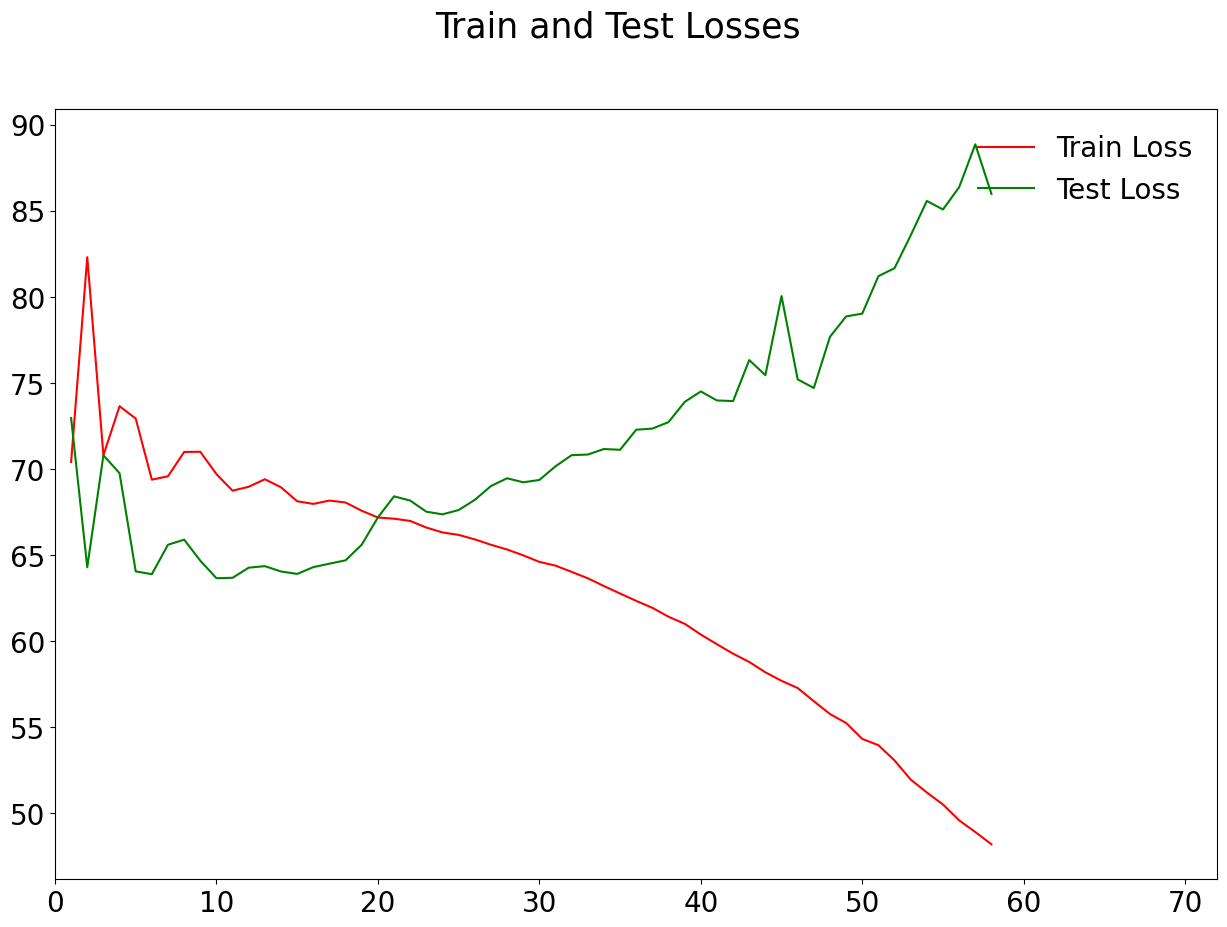

In [75]:
plot_losses('losses.pkl')

# CER 

In [44]:
print("Calculating CER.....")
cer = CER_from_wavs(model, wavs, ["राज्य सिक्किमको", "लगेर हानेमा गलत"], UNQ_CHARS)
#राज्य सिक्किमको
print(cer, "\n")

Calculating CER.....
CER -> 96.67%, 	 No.of sentences -> 2, 	 Time Taken -> 1.84 secs.
The total time taken for all sentences CER calculation is  1.84 secs.
0.9666666666666667 

